In [1]:
%matplotlib inline

import pybedtools
from clipper.src import CLIP_analysis
from gscripts.general import region_helpers
from clipper.src import CLIP_analysis

import os
from gscripts.general import dataviz
from matplotlib_venn import venn2, venn3
import glob
import os
import numpy as np
import pandas as pd
from gscripts import GO
import matplotlib.pyplot as plt

img_dir = "/home/gpratt/Dropbox/Analysis/"

/home/gpratt/anaconda/lib/python2.7/site-packages/IPython/html.py:14: ShimWarning: The `IPython.html` package has been deprecated. You should import from `notebook` instead. `IPython.html.widgets` has moved to `ipywidgets`.
  "`IPython.html.widgets` has moved to `ipywidgets`.", ShimWarning)


In [44]:
import matplotlib as mpl
legend = None

OUTSIDE_LEGEND_SAVEFIG_KWS = dict(bbox_extra_artists=(legend,),
                                  bbox_inches='tight')
from matplotlib import rc

mpl.rcParams['svg.fonttype'] = 'none'

rc('text', usetex=False) 
rc('font',**{'family':'sans-serif','sans-serif':['Helvetica']})

In [2]:
%load_ext autoreload
%autoreload 2

reload(CLIP_analysis)
reload(dataviz)

<module 'gscripts.general.dataviz' from '/home/gpratt/anaconda/lib/python2.7/site-packages/gscripts-0.1.6-py2.7.egg/gscripts/general/dataviz.pyc'>

In [3]:
def make_clipper_ish(interval):
    interval.name = interval[7]
    interval[6] = interval.start
    interval[7] = interval.stop
    return interval

def filter_data(interval):
    #col4 is -log10 p-val
    #col5 is -log2 fold enrichment
    return (float(interval[4]) >= 3) and (float(interval[3]) >= 3)

#Factor this to a helpers function
def gencode_to_ensembl(gene_list):
    for gene in gene_list:
        yield gene.split(".")[0]

In [4]:
gene_id_to_name = region_helpers.gene_id_to_name("/projects/ps-yeolab/genomes/hg19/gencode/v19/gencode.v19.annotation.gtf.db")
gene_id_to_type = region_helpers.gene_id_to_type("/projects/ps-yeolab/genomes/hg19/gencode/v19/gencode.v19.annotation.gtf.db")
ensembl_id_to_name = {key.split(".")[0]: value for key, value in gene_id_to_name.items()}

name_to_gene_id = {value: key for key, value in gene_id_to_name.items()}

In [7]:
inputnorm_dir = '/home/bay001/projects/parp13_ago2_20151203/data/input_norm'
ss_wt = pybedtools.BedTool(os.path.join(inputnorm_dir,'SA2_01.basedon_SA2_01.peaks.l2inputnormnew.bed.compressed.bed.annotated'))
p3_wt = pybedtools.BedTool(os.path.join(inputnorm_dir,'SA4_01.basedon_SA4_01.peaks.l2inputnormnew.bed.compressed.bed.annotated'))
ss_ko = pybedtools.BedTool(os.path.join(inputnorm_dir,'SA6_01.basedon_SA6_01.peaks.l2inputnormnew.bed.compressed.bed'))

In [58]:
ss_wt_filtered = ss_wt.filter(filter_data).saveas()
p3_wt_filtered = p3_wt.filter(filter_data).saveas()


In [8]:
len(ss_wt.filter(filter_data)), len(p3_wt.filter(filter_data)), len(ss_ko.filter(filter_data))

(157, 307, 517)

In [10]:
ss_cleaned = ss_wt.intersect(ss_ko, v=True, s=True).filter(filter_data).saveas("SA2_01.basedon_SA2_01.peaks.l2inputnormnew.bed.compressed.bed.annotated")
p3_cleaned = p3_wt.intersect(ss_ko, v=True, s=True).filter(filter_data).saveas("SA4_01.basedon_SA4_01.peaks.l2inputnormnew.bed.compressed.bed.annotated")

In [11]:
len(p3_cleaned.intersect(ss_cleaned, s=True, u=True)), len(ss_cleaned.intersect(p3_cleaned, s=True, u=True))

(0, 0)

In [ ]:
# wt_cleaned.each(make_clipper_ish).saveas(os.path.basename(wt_cleaned.fn) + ".clipper")
# mimic_cleaned.each(make_clipper_ish).saveas(os.path.basename(mimic_cleaned.fn) + ".clipper")

# clip_analysis  '--clusters' '/home/gpratt/ipython_notebook/SA2_01.basedon_SA2_01.peaks.l2inputnormnew.bed.compressed.bed.annotated.clipper'  '-s' 'hg19_v19'  '--bam' '/projects/ps-yeolab/encode/analysis/encode_v13/SA2_WT_SS_PARP_PARP.merged.r2.bam'  '--AS_Structure' '/projects/ps-yeolab/genomes/hg19/hg19data4'  '--genome_location' '/projects/ps-yeolab/genomes/hg19/chromosomes/all.fa'  '--phastcons_location' '/projects/ps-yeolab/genomes/hg19/hg19_phastcons.bw'  '--nrand' '3'  '--runPhast'  '--metrics' 'SA4.metrics'  '--gff_db' '/projects/ps-yeolab/genomes/hg19/gencode/v19/gencode.v19.annotation.gtf.db'
# clip_analysis  '--clusters' '/home/gpratt/ipython_notebook/SA4_01.basedon_SA4_01.peaks.l2inputnormnew.bed.compressed.bed.annotated.clipper'  '-s' 'hg19_v19'  '--bam' '/projectencode/analysis/encode_v13/SA4_WT_3P_PARP_PARP.merged.r2.bam'  '--AS_Structure' '/projects/ps-yeolab/genomes/hg19/hg19data4'  '--genome_location' '/projects/ps-yeolab/genomes/hg19/chromosomes/all.fa'  'location' '/projects/ps-yeolab/genomes/hg19/hg19_phastcons.bw'  '--nrand' '3'  '--runPhast'  '--metrics' 'rbfox2.metrics'  '--gff_db' '/projects/ps-yeolab/genomes/hg19/gencode/v19/gencode.v19.annotationSA4.metrics'  '--gff_db' '/projects/ps-yeolab/genomes/hg19/gencode/v19/gencode.v19.annotation.gtf.db'


In [12]:
diff_exp_parp = pd.concat({os.path.basename(item.split(".")[0]): pd.read_csv(item, index_col=0) for item in glob.glob("/home/gpratt/ad-hoc/*.csv")})
#sig_diff_exp_parp = diff_exp_parp[(diff_exp_parp.padj < .05)]

#exp 1, treatment, genotype, exp2 treatment, genotype
index = {"ko_vs_wt_3p-ssRNA_diffexp_gene_name": ("ko", "3p", "wt", "3p"),
         "ko_vs_wt_ssRNA_diffexp_gene_name": ("ko", "ss", "wt", "ss"),
         "ss_vs_3p_ko_diffexp_gene_name": ("ko", "3p", "ko", "ss"),
         "ss_vs_3p_wt_diffexp_gene_name": ("wt", "3p", "wt", "ss")
  }      

new_index = []
for item in diff_exp_parp.index:
    new_index.append(index[item[0]] + item[1:])
diff_exp_parp.index = pd.MultiIndex.from_tuples(new_index, names=["exp1_treatment", "exp1_genotype", "exp2_treatment", "exp2_genotype", "gene_id"])

#sig_diff_exp_parp = diff_exp_parp[(diff_exp_parp.padj < .05) & (np.abs(np.power(diff_exp_parp.log2FoldChange, 2)) > 1.5)]
sig_diff_exp_parp = diff_exp_parp[(diff_exp_parp.padj < .05) & (np.abs(diff_exp_parp.log2FoldChange) > 1.5)]


In [13]:
sig_diff_exp_parp.groupby(level=[0,1,2,3]).count()

Gencode V19  \
exp1_treatment exp1_genotype exp2_treatment exp2_genotype                
ko             3p            ko             ss                      53   
                             wt             3p                     253   
               ss            wt             ss                     235   
wt             3p            wt             ss                      88   

                                                           baseMean  \
exp1_treatment exp1_genotype exp2_treatment exp2_genotype             
ko             3p            ko             ss                   53   
                             wt             3p                  253   
               ss            wt             ss                  235   
wt             3p            wt             ss                   88   

                                                           log2FoldChange  \
exp1_treatment exp1_genotype exp2_treatment exp2_genotype                   
ko             3p            ko             ss                         53   
                             wt             3p                        253   
               ss            wt             ss                        235   
wt             3p            wt             ss                         88   

                                                           lfcSE  stat  \
exp1_treatment exp1_genotype exp2_treatment exp2_genotype                
ko             3p            ko             ss                53    53   
                             wt             3p               253   253   
               ss            wt             ss               235   235   
wt             3p            wt             ss                88    88   

                                                           pvalue  padj  \
exp1_treatment exp1_genotype exp2_treatment exp2_genotype                 
ko             3p            ko             ss                 53    53   
                             wt             3p                253   253   
               ss            wt             ss                235   235   
wt             3p            wt             ss                 88    88   

                                                           Gene_name  
exp1_treatment exp1_genotype exp2_treatment exp2_genotype             
ko             3p            ko             ss                    36  
                             wt             3p                   171  
               ss            wt             ss                   161  
wt             3p            wt             ss                    61

In [14]:
sig_diff_exp_parp[sig_diff_exp_parp.log2FoldChange > 0].groupby(level=[0,1,2,3]).count()

Gencode V19  \
exp1_treatment exp1_genotype exp2_treatment exp2_genotype                
ko             3p            ko             ss                      53   
                             wt             3p                     112   
               ss            wt             ss                     119   
wt             3p            wt             ss                      88   

                                                           baseMean  \
exp1_treatment exp1_genotype exp2_treatment exp2_genotype             
ko             3p            ko             ss                   53   
                             wt             3p                  112   
               ss            wt             ss                  119   
wt             3p            wt             ss                   88   

                                                           log2FoldChange  \
exp1_treatment exp1_genotype exp2_treatment exp2_genotype                   
ko             3p            ko             ss                         53   
                             wt             3p                        112   
               ss            wt             ss                        119   
wt             3p            wt             ss                         88   

                                                           lfcSE  stat  \
exp1_treatment exp1_genotype exp2_treatment exp2_genotype                
ko             3p            ko             ss                53    53   
                             wt             3p               112   112   
               ss            wt             ss               119   119   
wt             3p            wt             ss                88    88   

                                                           pvalue  padj  \
exp1_treatment exp1_genotype exp2_treatment exp2_genotype                 
ko             3p            ko             ss                 53    53   
                             wt             3p                112   112   
               ss            wt             ss                119   119   
wt             3p            wt             ss                 88    88   

                                                           Gene_name  
exp1_treatment exp1_genotype exp2_treatment exp2_genotype             
ko             3p            ko             ss                    36  
                             wt             3p                    74  
               ss            wt             ss                    82  
wt             3p            wt             ss                    61

In [15]:
sig_diff_exp_parp[sig_diff_exp_parp.log2FoldChange < 0].groupby(level=[0,1,2,3]).count()

Gencode V19  \
exp1_treatment exp1_genotype exp2_treatment exp2_genotype                
ko             3p            wt             3p                     141   
               ss            wt             ss                     116   

                                                           baseMean  \
exp1_treatment exp1_genotype exp2_treatment exp2_genotype             
ko             3p            wt             3p                  141   
               ss            wt             ss                  116   

                                                           log2FoldChange  \
exp1_treatment exp1_genotype exp2_treatment exp2_genotype                   
ko             3p            wt             3p                        141   
               ss            wt             ss                        116   

                                                           lfcSE  stat  \
exp1_treatment exp1_genotype exp2_treatment exp2_genotype                
ko             3p            wt             3p               141   141   
               ss            wt             ss               116   116   

                                                           pvalue  padj  \
exp1_treatment exp1_genotype exp2_treatment exp2_genotype                 
ko             3p            wt             3p                141   141   
               ss            wt             ss                116   116   

                                                           Gene_name  
exp1_treatment exp1_genotype exp2_treatment exp2_genotype             
ko             3p            wt             3p                    97  
               ss            wt             ss                    79

In [38]:
foo = diff_exp_parp[diff_exp_parp.Gene_name == "IFIT2"].copy()

In [41]:
foo.drop(["Gencode V19", "baseMean", "lfcSE", "stat", "pvalue"], axis=1)

log2FoldChange  \
exp1_treatment exp1_genotype exp2_treatment exp2_genotype gene_id                           
ko             3p            wt             3p            ENSG00000119922       -1.032045   
               ss            wt             ss            ENSG00000119922       -0.737931   
               3p            ko             ss            ENSG00000119922        5.878435   
wt             3p            wt             ss            ENSG00000119922        5.910270   

                                                                                    padj  \
exp1_treatment exp1_genotype exp2_treatment exp2_genotype gene_id                          
ko             3p            wt             3p            ENSG00000119922   1.621211e-04   
               ss            wt             ss            ENSG00000119922   7.193661e-02   
               3p            ko             ss            ENSG00000119922   0.000000e+00   
wt             3p            wt             ss            ENSG00000119922  2.043142e-232   

                                                                          Gene_name  
exp1_treatment exp1_genotype exp2_treatment exp2_genotype gene_id                    
ko             3p            wt             3p            ENSG00000119922     IFIT2  
               ss            wt             ss            ENSG00000119922     IFIT2  
               3p            ko             ss            ENSG00000119922     IFIT2  
wt             3p            wt             ss            ENSG00000119922     IFIT2

WT vs ('ko', '3p', 'ko', 'ss')
IFIT2
mock vs ('ko', '3p', 'ko', 'ss')
CCL5, IFIT2, RSAD2
WT vs ('ko', '3p', 'wt', '3p')

mock vs ('ko', '3p', 'wt', '3p')
CCL5
WT vs ('ko', 'ss', 'wt', 'ss')

mock vs ('ko', 'ss', 'wt', 'ss')

WT vs ('wt', '3p', 'wt', 'ss')
IFIT2
mock vs ('wt', '3p', 'wt', 'ss')
CCL5, IFIT2, RSAD2


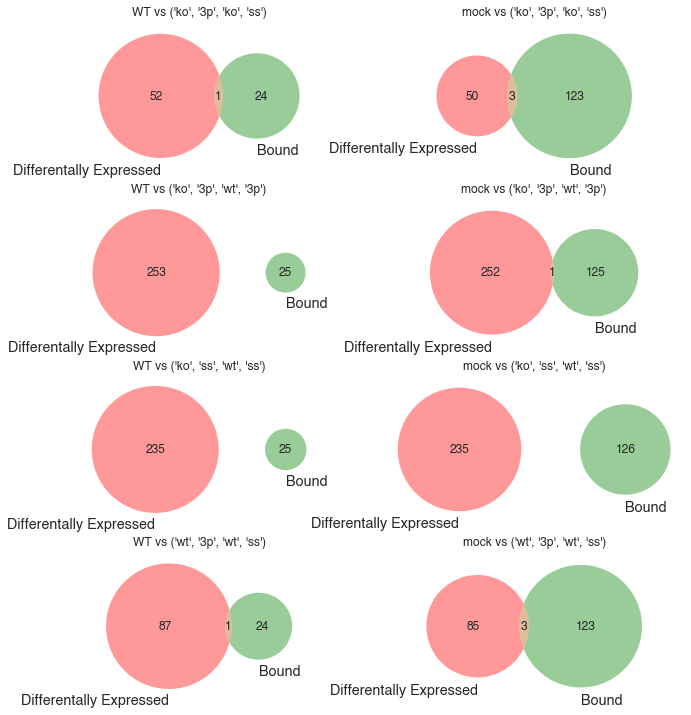

In [19]:
count = 0
with dataviz.Figure(os.path.join(img_dir, "de_vs_binding_parp.svg"), figsize=(10, 10)) as fig:
    
    for x, (name, df) in enumerate(sig_diff_exp_parp.groupby(level=[0,1,2,3])):
        count += 1
        ax = fig.add_subplot(4,2,count)

        venn2([set(df['Gencode V19'].values), 
               set([interval[-1] for interval in ss_cleaned])],
           set_labels =("Differentally Expressed", "Bound"),
               ax=ax
               

          )
        
        print "WT vs {}".format(name)
        print ", ".join([gene_id_to_name[item] for item in set(df['Gencode V19'].values) & set([interval[-1] for interval in ss_cleaned])])
        
        ax.set_title("WT vs {}".format(name), fontsize=12)
        count += 1
        ax = fig.add_subplot(4,2,count)

        venn2([set(df['Gencode V19'].values), set([interval[-1] for interval in p3_cleaned])],
           set_labels =("Differentally Expressed", "Bound"),
              ax=ax
    )
        ax.set_title("mock vs {}".format(name), fontsize=12)
        
        print "mock vs {}".format(name)
        print ", ".join([gene_id_to_name[item] for item in set(df['Gencode V19'].values) & set([interval[-1] for interval in p3_cleaned])])

Send Anthony and co overlapping genes for DE and binding

# Get genes changing that are unique for the KO and not WT 

/home/gpratt/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:6: PerformanceWarning: indexing past lexsort depth may impact performance.
/home/gpratt/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:7: PerformanceWarning: indexing past lexsort depth may impact performance.
/home/gpratt/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:15: PerformanceWarning: indexing past lexsort depth may impact performance.
/home/gpratt/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:16: PerformanceWarning: indexing past lexsort depth may impact performance.
/home/gpratt/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:27: PerformanceWarning: indexing past lexsort depth may impact performance.
/home/gpratt/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:28: PerformanceWarning: indexing past lexsort depth may impact performance.
/home/gpratt/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:36: PerformanceWarning: indexing past lexs

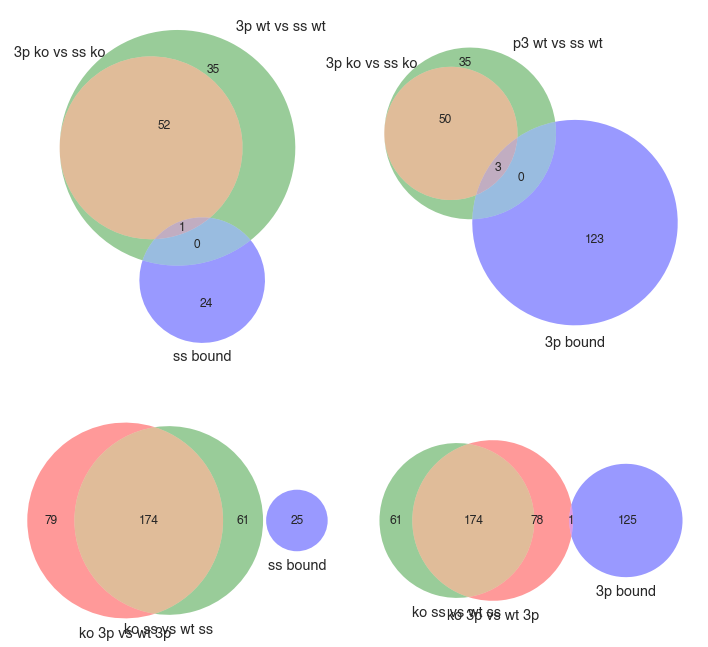

In [46]:
with dataviz.Figure(os.path.join(img_dir, "de_control_and_binding.svg"), figsize=(10, 10)) as fig:
    
    ax = fig.add_subplot(2,2,1)

    #Genes 
    venn3([set(sig_diff_exp_parp.ix["ko", "3p", "ko","ss"]['Gencode V19'].values), 
       set(sig_diff_exp_parp.ix["wt", "3p", "wt","ss"]['Gencode V19'].values),
       set([interval[-1] for interval in ss_cleaned])
          ],
          set_labels =("3p ko vs ss ko", "3p wt vs ss wt", "ss bound"),
          ax=ax
         )
    
    ax = fig.add_subplot(2,2,3)
    venn3([set(sig_diff_exp_parp.ix["ko", "3p", "wt", "3p"]['Gencode V19'].values), 
           set(sig_diff_exp_parp.ix["ko", "ss", "wt", "ss"]['Gencode V19'].values),
           set([interval[-1] for interval in ss_cleaned])
          ],
          set_labels =("ko 3p vs wt 3p", "ko ss vs wt ss", "ss bound"),
          ax=ax
         )
        
        

    #Genes 
    ax = fig.add_subplot(2,2,2)
    venn3([set(sig_diff_exp_parp.ix["ko", "3p", "ko","ss"]['Gencode V19'].values), 
       set(sig_diff_exp_parp.ix["wt", "3p", "wt","ss"]['Gencode V19'].values),
       set([interval[-1] for interval in p3_cleaned])
          ],
          set_labels =("3p ko vs ss ko", "p3 wt vs ss wt", "3p bound"),
          ax=ax
         )
    
    ax = fig.add_subplot(2,2,4)
    venn3([set(sig_diff_exp_parp.ix["ko", "3p", "wt", "3p"]['Gencode V19'].values), 
           set(sig_diff_exp_parp.ix["ko", "ss", "wt", "ss"]['Gencode V19'].values),
           set([interval[-1] for interval in p3_cleaned])
          ],
          set_labels =("ko 3p vs wt 3p", "ko ss vs wt ss", "3p bound"),
          ax=ax
         )
        


In [55]:
len(p3_wt_filtered)

0

In [64]:
gene_id_to_name['ENSG00000166710.13']

'B2M'

In [63]:
(set(sig_diff_exp_parp.ix["wt", "3p", "wt","ss"]['Gencode V19'].values) & set([interval[-1] for interval in p3_wt_filtered])) - set(sig_diff_exp_parp.ix["ko", "3p", "ko","ss"]['Gencode V19'].values)

/home/gpratt/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:1: PerformanceWarning: indexing past lexsort depth may impact performance.
  if __name__ == '__main__':


{'ENSG00000166710.13'}

/home/gpratt/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:6: PerformanceWarning: indexing past lexsort depth may impact performance.
/home/gpratt/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:7: PerformanceWarning: indexing past lexsort depth may impact performance.
/home/gpratt/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:15: PerformanceWarning: indexing past lexsort depth may impact performance.
/home/gpratt/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:16: PerformanceWarning: indexing past lexsort depth may impact performance.
/home/gpratt/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:27: PerformanceWarning: indexing past lexsort depth may impact performance.
/home/gpratt/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:28: PerformanceWarning: indexing past lexsort depth may impact performance.
/home/gpratt/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:36: PerformanceWarning: indexing past lexs

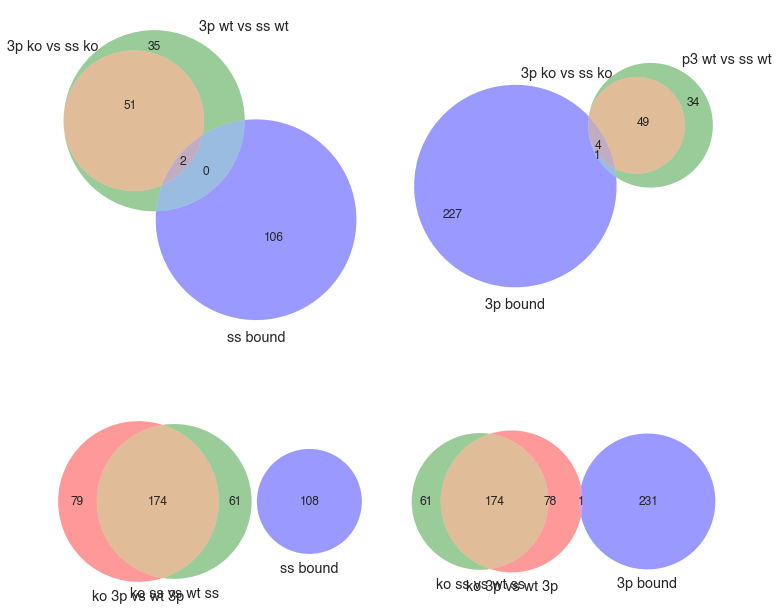

In [59]:
with dataviz.Figure(os.path.join(img_dir, "de_control_and_binding.svg"), figsize=(10, 10)) as fig:
    
    ax = fig.add_subplot(2,2,1)

    #Genes 
    venn3([set(sig_diff_exp_parp.ix["ko", "3p", "ko","ss"]['Gencode V19'].values), 
       set(sig_diff_exp_parp.ix["wt", "3p", "wt","ss"]['Gencode V19'].values),
       set([interval[-1] for interval in ss_wt_filtered])
          ],
          set_labels =("3p ko vs ss ko", "3p wt vs ss wt", "ss bound"),
          ax=ax
         )
    
    ax = fig.add_subplot(2,2,3)
    venn3([set(sig_diff_exp_parp.ix["ko", "3p", "wt", "3p"]['Gencode V19'].values), 
           set(sig_diff_exp_parp.ix["ko", "ss", "wt", "ss"]['Gencode V19'].values),
           set([interval[-1] for interval in ss_wt_filtered])
          ],
          set_labels =("ko 3p vs wt 3p", "ko ss vs wt ss", "ss bound"),
          ax=ax
         )
        
        

    #Genes 
    ax = fig.add_subplot(2,2,2)
    venn3([set(sig_diff_exp_parp.ix["ko", "3p", "ko","ss"]['Gencode V19'].values), 
       set(sig_diff_exp_parp.ix["wt", "3p", "wt","ss"]['Gencode V19'].values),
       set([interval[-1] for interval in p3_wt_filtered])
          ],
          set_labels =("3p ko vs ss ko", "p3 wt vs ss wt", "3p bound"),
          ax=ax
         )
    
    ax = fig.add_subplot(2,2,4)
    venn3([set(sig_diff_exp_parp.ix["ko", "3p", "wt", "3p"]['Gencode V19'].values), 
           set(sig_diff_exp_parp.ix["ko", "ss", "wt", "ss"]['Gencode V19'].values),
           set([interval[-1] for interval in p3_wt_filtered])
          ],
          set_labels =("ko 3p vs wt 3p", "ko ss vs wt ss", "3p bound"),
          ax=ax
         )
        


# GO Analysis

In [26]:
hg19go = GO.GO(GOFile="/projects/ps-yeolab/genomes/hg19/hg19.ENSG_to_GO.txt.gz")

In [34]:
from matplotlib import pyplot

In [30]:
result = {}
for name, df in sig_diff_exp_parp.groupby(level=["exp1_treatment", "exp1_genotype", "exp2_treatment", "exp2_genotype"]):
    print name
    result[name] = hg19go.enrichment(gencode_to_ensembl(set(df['Gencode V19'].values)))
    
result = pd.concat(result)
result = result[result['Bonferroni-corrected Hypergeometric p-Value'] < .05]

('ko', '3p', 'ko', 'ss')
('ko', '3p', 'wt', '3p')
('ko', 'ss', 'wt', 'ss')
('wt', '3p', 'wt', 'ss')


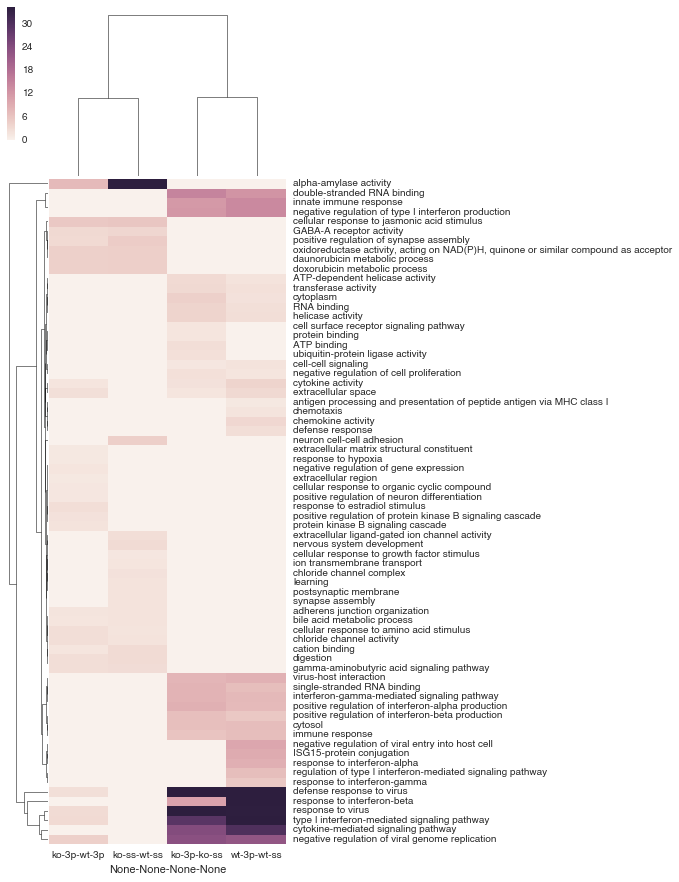

In [45]:
cg = dataviz.plot_go_enrichment(result, figsize=(5,15))
plt.setp(cg.ax_heatmap.yaxis.get_majorticklabels(), rotation=0)
fig = pyplot.gcf()
fig.savefig(os.path.join(img_dir, "go_analysis.svg"))
fig.savefig(os.path.join(img_dir, "go_analysis.pdf"))  